In [ ]:
# Titanic 구현
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
df = pd.read_csv('../data/titanic/train.csv')

# 학습에 필요없는 columns 삭제
df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=True)

# 데이터 전처리
# 1. 성별 전처리
gender_mapping = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(gender_mapping)

# 2. SibSp, Parch 하나로 합치기
df["family"] = df['SibSp'] + df['Parch']
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# 3. 결측치 확인
df.isnull().sum()

# 3-1 Embarked 결측치 처리, Q로 채우기
df['Embarked'] = df['Embarked'].fillna('Q')

# 문자 - 숫자로 변경
Embarked_mapping = {'S':0, 'C':1, 'Q':2}
df['Embarked'] = df['Embarked'].map(Embarked_mapping)

# 3-2 Age 결측치 처리, 평균으로
df['Age'] = df['Age'].fillna(df['Age'].mean())

# 범주형 데이터로 변환(binning)
df.loc[df['Age'] < 8, 'Age'] = 0  # 8살 미만 0
df.loc[(df['Age'] < 20) & (df['Age'] >= 8), 'Age'] = 1  # 8-20살 1
df.loc[(df['Age'] < 65) & (df['Age'] >= 20), 'Age'] = 2  # 20-65 2
df.loc[df['Age'] >= 65, 'Age'] = 3  # 65이상 3

# 4. 정규화 이미 어느정도 되서 넘어감

# 5. trian & validation, 7:3으로 나누기
train_data = df.iloc[:int(df.shape[0] * 0.7)]
val_data = df.iloc[int(df.shape[0] * 0.7):]

# 6-1. Train Data Set
train_x_data = train_data.drop(['Survived'], axis=1, inplace=False).values
train_t_data = train_data['Survived'].values.reshape(-1,1)

# 6-2. Validation Data Set
val_x_data = val_data.drop(['Survived'], axis=1, inplace=False).values
val_t_data = val_data['Survived'].values.reshape(-1,1)

In [ ]:
# Tensorflow

# placeholder
X = tf.placeholder(shape=[None,5], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([5,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='weight')

# H
logit = tf.matmul(X, W) + b
H = tf.sigmoid(logit)

# loss
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, 
                                                              labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
# learning
for step in range(300000):
    _,W_val,b_val,loss_val = sess.run([train,W,b,loss], 
                                      feed_dict={X: train_x_data, T: train_t_data})
    if step % 30000 == 0:
        print('W:{},b:{},loss:{}'.format(W_val,b_val,loss_val))

In [ ]:
# 정확도 측정 
# predict용 node
predict = tf.cast(H > 0.5, dtype=tf.float32)

# predict와 val_t_data와 비교
correct = tf.equal(predict, T)

# 정확도 계산 node
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

accuracy_val = sess.run(accuracy, feed_dict={X: val_x_data, T:val_t_data})
print('Model의 정확도 : {}'.format(accuracy_val))

- BMI 예제

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

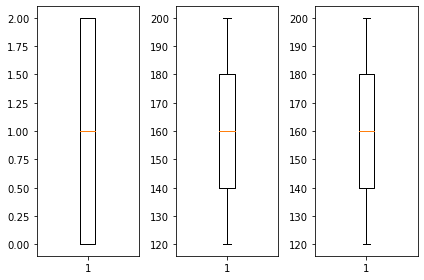

In [2]:
df = pd.read_csv('../data/bmi/bmi.csv', skiprows=3)

# 결측치 확인
df.isnull().sum()

# 이상치 확인fat
fig = plt.figure()

fig_1 = fig.add_subplot(1,3,1)
fig_2 = fig.add_subplot(1,3,2)
fig_3 = fig.add_subplot(1,3,3)

fig_1.boxplot(df['label'])
fig_2.boxplot(df['height'])
fig_3.boxplot(df['height'])

fig.tight_layout()
plt.show() # 이상치 없음

In [3]:
# training data set
x_data = df[['height', 'height']].values.reshape(-1,2)
t_data = df['label'].values.reshape(-1,1) # One-Hot Encoding 추가 적용해야함

# 정규화
scaler_x = MinMaxScaler()
scaler_x.fit(x_data)
norm_x_data = scaler_x.transform(x_data)

# One-Hot Encoding with tensorflow
sess = tf.Session()

# one_hot(data, depth(label의 종류))
norm_t_data = sess.run(tf.one_hot(t_data, depth=3)).reshape(-1,3)

In [10]:
# trian test split
train_x_data = norm_x_data[:int(norm_x_data.shape[0]*0.7)]
train_t_data = norm_t_data[:int(norm_t_data.shape[0]*0.7)]

test_x_data = norm_x_data[int(norm_x_data.shape[0]*0.7):]
test_t_data = norm_t_data[int(norm_t_data.shape[0]*0.7):]

In [4]:
# placeholder
X = tf.placeholder(shape=[None,2], dtype=tf.float32)
T = tf.placeholder(shape=[None,3], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([2,3]))
b = tf.Variable(tf.random.normal([3]))

# Hypothesis
logit = tf.matmul(X, W) + b
H = tf.nn.softmax(logit)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, 
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# 초기화
sess.run(tf.global_variables_initializer())

In [53]:
for step in range(300000):
    _,W_val,b_val,loss_val = sess.run([train,W,b,loss], 
                                      feed_dict={X : train_x_data, T : train_t_data })
    
    if step % 30000 == 0:
        print('W:{},b:{},loss:{}'.format(W_val,b_val,loss_val))

W:[[-2.2523468  -0.20692527 -0.9655102 ]
 [ 0.8849381   0.99544483  1.119509  ]],b:[ 0.589837   -0.7967857  -0.39243087],loss:1.2540440559387207
W:[[-2.0316021  -0.23001924 -1.1631815 ]
 [ 1.1057042   0.9723495   0.92186135]],b:[ 0.37082666 -0.79360753 -0.17658113],loss:1.1635234355926514
W:[[-1.8389592  -0.24512987 -1.3406895 ]
 [ 1.2983546   0.9572655   0.7443041 ]],b:[ 0.17038296 -0.7842431   0.01452813],loss:1.0919276475906372
W:[[-1.6697133  -0.25519422 -1.4998682 ]
 [ 1.4676006   0.9471142   0.58511406]],b:[-0.00960633 -0.7720262   0.18223377],loss:1.0355747938156128
W:[[-1.5204158  -0.26189157 -1.6425214 ]
 [ 1.6168981   0.94055575  0.44247094]],b:[-0.17072424 -0.75774926  0.32941478],loss:0.9911226034164429
W:[[-1.3880682  -0.26618725 -1.7705615 ]
 [ 1.7492456   0.93629766  0.3143831 ]],b:[-0.31538126 -0.7429554   0.45907566],loss:0.9558006525039673
W:[[-1.2698646  -0.26911205 -1.8859512 ]
 [ 1.8674493   0.9333914   0.19904803]],b:[-0.44570118 -0.7269682   0.57413155],loss:0.92

In [54]:
# prediction
result = sess.run(H, feed_dict={X: test_x_data})

# 모델의 값
print(result.argmax(axis=1))

# 실제 값
print(test_t_data.argmax(axis=1))

accuracy_list = np.equal(result.argmax(axis=1), test_t_data.argmax(axis=1))

print(accuracy_list.sum()/len(accuracy_list))

[2 0 2 ... 2 0 2]
[0 1 2 ... 1 1 1]
0.6183333333333333


- [argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html#numpy.argmax): 최대값의 index 반환
- [equal()](https://numpy.org/doc/stable/reference/generated/numpy.equal.html?highlight=equal) : ndarray 비교